In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/keystroke1/User1.csv
/kaggle/input/keystroke1/User9.csv


In [3]:
!pip install torchinfo pandas scikit-learn matplotlib seaborn

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math


In [6]:
import pandas as pd

# === Load Keystroke CSVs ===
df_user1 = pd.read_csv("/kaggle/input/keystroke1/User1.csv")
df_user9 = pd.read_csv("/kaggle/input/keystroke1/User9.csv")

# === Add Username Labels ===
df_user1['Username'] = 'User1'
df_user9['Username'] = 'User9'

# === Combine All Data ===
df = pd.concat([df_user1, df_user9], ignore_index=True)


# === Filter out system events like RESTART if necessary ===
df = df[df['EventType'].isin(['press', 'release'])]

# === Display Info ===
print("✅ Combined shape:", df.shape)
print(df.head())


✅ Combined shape: (357137, 4)
                 Timestamp EventType         Key Username
1  2017-03-20 01:25:20,894   release   Key.alt_l    User1
2  2017-03-20 01:25:20,910   release  Key.ctrl_l    User1
3  2017-03-20 01:25:20,910   release   Key.shift    User1
4  2017-03-20 01:25:20,910   release     Key.cmd    User1
5  2017-03-20 01:25:20,910   release   Key.alt_r    User1


In [7]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

SEQ_LEN = 50
X, y = [], []

# Sort by timestamp to maintain correct order
df = df.sort_values(by='Timestamp').reset_index(drop=True)

# Encode Usernames 
user_encoder = LabelEncoder()
df['UserEncoded'] = user_encoder.fit_transform(df['Username'])

# Encode Keys (categorical key strings to integers)
key_encoder = LabelEncoder()
df['KeyEncoded'] = key_encoder.fit_transform(df['Key'].astype(str))

# Only keep required column for input
features = ['KeyEncoded']

# === Build Sequences ===
for i in tqdm(range(len(df) - SEQ_LEN)):
    segment = df.iloc[i:i + SEQ_LEN]
    users = segment['UserEncoded']

    if len(set(users)) == 1:  # Ensure sequence belongs to one user
        key_seq = segment['KeyEncoded'].values  # Shape: [SEQ_LEN]
        X.append(key_seq)
        y.append(users.iloc[0])

# Convert to tensors
X = torch.tensor(X, dtype=torch.long)  # Shape: [N, SEQ_LEN]
y = torch.tensor(y, dtype=torch.long)

print(f"✅ Final Tensor Shapes: X = {X.shape}, y = {y.shape}")


100%|██████████| 357087/357087 [00:25<00:00, 13969.06it/s]


✅ Final Tensor Shapes: X = torch.Size([282254, 50]), y = torch.Size([282254])


/tmp/ipykernel_35/2025474816.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.long)  # Shape: [N, SEQ_LEN]


In [8]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


✅ Using device: cuda


In [9]:
X_np = X.numpy()
y_np = y.numpy()

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X_np, y_np, test_size=0.2, stratify=y_np, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_np), y=y_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)


Class Weights: tensor([0.9070, 1.1143], device='cuda:0')


In [18]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        H = self.num_heads
        d_k = self.d_k

        Q = self.q(x).view(B, T, H, d_k).transpose(1, 2)
        K = self.k(x).view(B, T, H, d_k).transpose(1, 2)
        V = self.v(x).view(B, T, H, d_k).transpose(1, 2)

        scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)
        weights = torch.softmax(scores, dim=-1)
        output = weights @ V
        output = output.transpose(1, 2).contiguous().view(B, T, D)
        return self.out(output)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim=128, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout1(self.attn(x)))
        x = self.norm2(x + self.dropout2(self.ff(x)))
        return x

class KeystrokeTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=60, num_heads=6, num_layers=6, num_classes=2, ff_dim=128, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model, padding_idx=0)
        self.pos_enc = PositionalEncoding(d_model)

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)]
        )

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):  # x: [batch_size, seq_len]
        x = self.embedding(x)             # [batch_size, seq_len, d_model]
        x = self.pos_enc(x)               # Add positional encoding
        x = self.transformer_blocks(x)    # Apply transformer layers
        x = x.mean(dim=1)                 # Global average pooling
        return self.classifier(x)         # Classification head


In [19]:
vocab_size = len(key_encoder.classes_)
model = KeystrokeTransformerClassifier(vocab_size=vocab_size).to(device)

# Class weights can be calculated using sklearn.utils.class_weight
loss_fn = nn.CrossEntropyLoss(weight=class_weights)  # Optional
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [20]:
def train(model, train_dl, val_dl, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        batch_count = 0

        for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
            xb = xb.long().to(device)   # 👈 Fix: Ensure input is LongTensor
            yb = yb.to(device)

            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_count += 1

        avg_loss = total_loss / batch_count

        # === Validation ===
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.long().to(device)  
                yb = yb.to(device)

                preds = model(xb)
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        print(f"✅ Epoch {epoch+1} | Avg Loss: {avg_loss:.4f} | Val Acc: {acc:.2%}")


In [21]:
train(model, train_dl, val_dl, epochs=10)

Epoch 1/10: 100%|██████████| 7057/7057 [00:56<00:00, 124.26it/s]


✅ Epoch 1 | Avg Loss: 0.4650 | Val Acc: 79.75%


Epoch 2/10: 100%|██████████| 7057/7057 [00:56<00:00, 124.94it/s]


✅ Epoch 2 | Avg Loss: 0.4200 | Val Acc: 80.35%


Epoch 3/10: 100%|██████████| 7057/7057 [00:56<00:00, 124.59it/s]


✅ Epoch 3 | Avg Loss: 0.4047 | Val Acc: 79.91%


Epoch 4/10: 100%|██████████| 7057/7057 [00:56<00:00, 124.90it/s]


✅ Epoch 4 | Avg Loss: 0.3885 | Val Acc: 82.95%


Epoch 5/10: 100%|██████████| 7057/7057 [00:56<00:00, 125.19it/s]


✅ Epoch 5 | Avg Loss: 0.3620 | Val Acc: 84.43%


Epoch 6/10: 100%|██████████| 7057/7057 [00:56<00:00, 124.38it/s]


✅ Epoch 6 | Avg Loss: 0.2943 | Val Acc: 90.71%


Epoch 7/10: 100%|██████████| 7057/7057 [00:56<00:00, 124.79it/s]


✅ Epoch 7 | Avg Loss: 0.2095 | Val Acc: 92.36%


Epoch 8/10: 100%|██████████| 7057/7057 [00:56<00:00, 125.58it/s]


✅ Epoch 8 | Avg Loss: 0.1857 | Val Acc: 93.27%


Epoch 9/10: 100%|██████████| 7057/7057 [00:56<00:00, 125.70it/s]


✅ Epoch 9 | Avg Loss: 0.1699 | Val Acc: 94.31%


Epoch 10/10: 100%|██████████| 7057/7057 [00:56<00:00, 124.75it/s]


✅ Epoch 10 | Avg Loss: 0.1588 | Val Acc: 94.32%


📋 Classification Report:
              precision    recall  f1-score   support

       User1       0.95      0.95      0.95     31120
       User9       0.94      0.93      0.94     25331

    accuracy                           0.94     56451
   macro avg       0.94      0.94      0.94     56451
weighted avg       0.94      0.94      0.94     56451



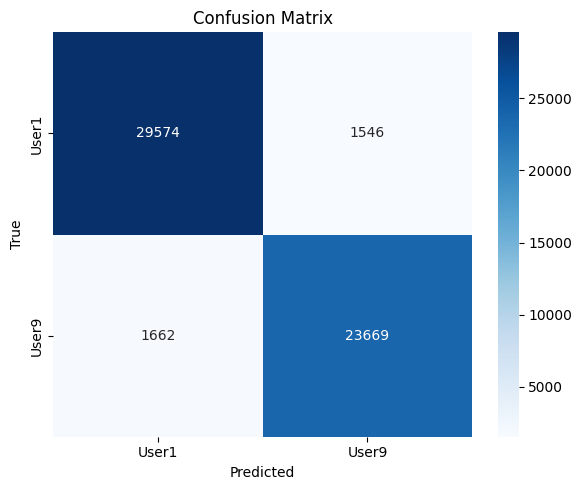

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.long().to(device)  # ✅ Ensure type is LongTensor
        yb = yb.to(device)
        preds = model(xb)
        y_true.extend(yb.tolist())
        y_pred.extend(preds.argmax(1).cpu().tolist())

# 📋 Classification Report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=user_encoder.classes_))

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=user_encoder.classes_, yticklabels=user_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


📐 AUC: 0.9880
⚖️ Equal Error Rate (EER): 0.0575 at threshold ≈ 0.4546


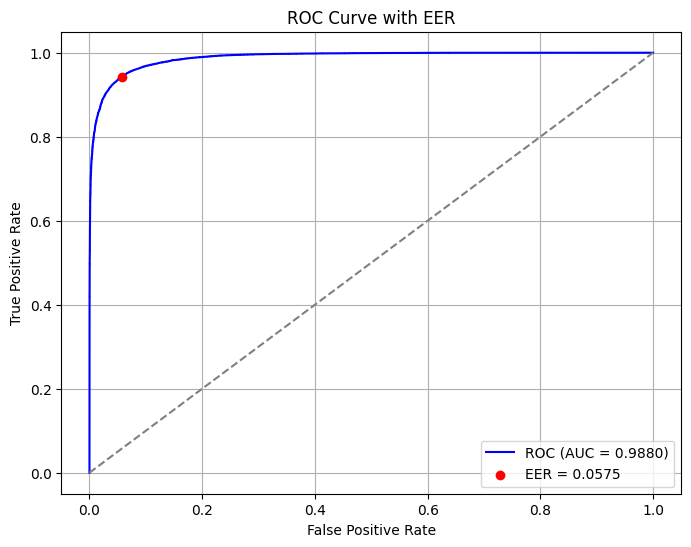

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

y_probs = []
with torch.no_grad():
    for xb, _ in val_dl:
        xb = xb.long().to(device)  # ✅ Cast to LongTensor
        probs = torch.softmax(model(xb), dim=1)[:, 1]  # Probability for User9
        y_probs.extend(probs.cpu().tolist())

# Compute ROC and AUC
auc = roc_auc_score(y_true, y_probs)
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

# Compute Equal Error Rate (EER)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

print(f"📐 AUC: {auc:.4f}")
print(f"⚖️ Equal Error Rate (EER): {eer:.4f} at threshold ≈ {eer_threshold:.4f}")

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.4f})', color='blue')
plt.scatter(eer, 1 - eer, color='red', label=f'EER = {eer:.4f}', zorder=10)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
import random
import torch

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_SAMPLES = 5
SEQ_LEN = 50

print("\n🔍 Predictions on Random 5 Samples Per User\n")

for user_name in user_encoder.classes_:
    user_label = user_encoder.transform([user_name])[0]

    # Filter dataframe for the user
    user_df = df[df['UserEncoded'] == user_label].reset_index(drop=True)

    print(f"--- User: {user_name} ---")

    for _ in range(NUM_SAMPLES):
        max_start = len(user_df) - SEQ_LEN
        if max_start <= 0:
            print("Not enough data for", user_name)
            break

        start_idx = random.randint(0, max_start)
        segment = user_df.iloc[start_idx:start_idx + SEQ_LEN]['KeyEncoded'].values

        sample = torch.tensor([segment], dtype=torch.long).to(device)  # ✅ LongTensor for embedding

        with torch.no_grad():
            pred = model(sample)
            pred_class = torch.argmax(pred, dim=1).item()

        pred_user = user_encoder.inverse_transform([pred_class])[0]
        print(f"True: {user_name} | Predicted: {pred_user}")
    print()



🔍 Predictions on Random 5 Samples Per User

--- User: User1 ---
True: User1 | Predicted: User1
True: User1 | Predicted: User1
True: User1 | Predicted: User1
True: User1 | Predicted: User1
True: User1 | Predicted: User1

--- User: User9 ---
True: User9 | Predicted: User9
True: User9 | Predicted: User9
True: User9 | Predicted: User9
True: User9 | Predicted: User9
True: User9 | Predicted: User9



In [26]:
# Count total samples
print(f"📦 Total Samples: {len(X)}")

# Count train/val split
print(f"🛠️ Training Samples: {len(X_train)}")
print(f"🧪 Validation Samples: {len(X_val)}")

# Count per user in training and validation
from collections import Counter

train_dist = Counter(y_train.tolist())
val_dist = Counter(y_val.tolist())

print("\n📊 Class Distribution:")
for label in sorted(train_dist.keys()):
    user = user_encoder.inverse_transform([label])[0]
    print(f"  {user} -> Train: {train_dist[label]} | Validation: {val_dist[label]}")


📦 Total Samples: 282254
🛠️ Training Samples: 225803
🧪 Validation Samples: 56451

📊 Class Distribution:
  User1 -> Train: 124478 | Validation: 31120
  User9 -> Train: 101325 | Validation: 25331
